# Data exploration on AffectNet raw dataset

In this notebook are shown the main features of the dataset and the distribution of the data fot the AffectNet dataset (concretly the) from emotic. The generated interim dataset from the raw data will be used to perform the data exploration, as in this format it will be easier to compute the necessary operations.

First I will import the necessary libraries and load the dataset and see an example of the data and its general annotations. Afterwards, I will perform a data sanity check to avoid having issues latter on. Then I will see the distribution of the data in the dataset and the distribution of the annotations in general. Finally, I will analyze it in more detail for each data split given and for each original db. Here is the main schematic of the data exploration:
* 0. Interim data loading
* 1. Data sanity check
* 2. Data exploration over all data
* 3. Data exploration over each split
* 4. Conclusions

**Note**: For visualizations I used *blue* to denote quantities or counts and *yellow* to show probabilities or normalized values*

# 0. Interim data loading
First I declare the necessary variables and import the necessary libraries.

In [45]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import Image
import sys

import altair as alt
alt.data_transformers.disable_max_rows() # delete the upper bound of entries in altair
alt.renderers.enable("html") # enable altair to render in html
# Suppress AltairDeprecationWarning warnings
import warnings
from altair.utils.deprecation import AltairDeprecationWarning
warnings.filterwarnings("ignore", category=AltairDeprecationWarning)

from prettytable import PrettyTable

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import INTERIM_AFFECTNET_DIR, INTERIM_COLUMNS_AFFECTNET, AFFECTNET_CAT_EMOT
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

Now we load the interim dataset:

In [46]:
annotations_path = Path(os.path.join(INTERIM_AFFECTNET_DIR, 'annotations'))

annotations = {}
for data_split in os.listdir(annotations_path):
    if data_split.endswith('.pkl'):
        file = os.path.join(annotations_path, data_split)
        data_part_name = data_split.split('_')[0]
        annotations[data_part_name] = pd.read_pickle(file)

# Sort the dictionary based on the order_list
desired_datasplit_order = ['train', 'val']
annotations = dict(sorted(annotations.items(), key=lambda x: desired_datasplit_order.index(x[0])))
print("The annotations found are for the datasplits:", list(annotations.keys()))

The annotations found are for the datasplits: ['train', 'val']


Now we see some rows of the train interim dataset:

In [47]:
annotations['train'].head()

,path,cat_emot,valence,arousal
0,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,0,-0.392238,-0.192678
1,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,3,0.303845,0.557880
2,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,1,0.479094,0.077429
3,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,1,0.787009,0.358637
4,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,3,-0.015873,0.626984


# 1. Data sanity check
Now I will perform a sanity check on the data to see if there are any issues with it. I will check that columns are equal to standard:

In [97]:
# Check if the vectors are equal
if np.array_equal(annotations['train'].columns, INTERIM_COLUMNS_AFFECTNET):
    print("The columns are equal to standard in the train split")
else:
    print("The columns are not equal to standard in the val split")

# Check if the vectors are equal
if np.array_equal(annotations['val'].columns, INTERIM_COLUMNS_AFFECTNET):
    print("The columns are equal to standard in the val split")
else:
    print("The columns are not equal to standard in the val split")

The columns are equal to standard in the train split
The columns are equal to standard in the val split


Now check that data types are correct:

In [98]:
for data_split, df in annotations.items():
    print(f"Data Split: {data_split}")
    print(df.dtypes)
    print()


Data Split: train
path         object
cat_emot      int64
valence     float64
arousal     float64
dtype: object

Data Split: val
path         object
cat_emot      int64
valence     float64
arousal     float64
dtype: object



And finally check that there are not null or NaN values:

In [99]:
for data_split, df in annotations.items():
    print(f"Data Split: {data_split}")
    print(df.isnull().sum())
    print()


Data Split: train
path        0
cat_emot    0
valence     0
arousal     0
dtype: int64

Data Split: val
path        0
cat_emot    0
valence     0
arousal     0
dtype: int64



Not null values are present, so the data sanity is correct. I can now proceed to the data exploration.

# 2. Data exploration over all data
First I will see the distribution of the data over all data splits. This way we can confirm how annotations are distributed over the whole dataset and then observe how many. I will see the distribution of the data in the following ways:
* 2.1 Continuous emotions
* 2.2 Categorical emotions
* 2.3 Continuous emotions conditioned to categorical emotions
* 2.4 Image size distribution



First I will compute the joint data distribution:

In [49]:
joint_annotations = pd.concat([annotations['train'], annotations['val']], ignore_index=True)

In [50]:
valence_stats = {
    'Continuous emotion:': 'Valence',
    'Max': round(joint_annotations['valence'].max(), 2),
    'Min': round(joint_annotations['valence'].min(), 2),
    'Mean': round(joint_annotations['valence'].mean(), 2),
    'Q1': round(joint_annotations['valence'].quantile(0.25), 2),
    'Q2 (Median)': round(joint_annotations['valence'].median(), 2),
    'Q3': round(joint_annotations['valence'].quantile(0.75), 2)
}

arousal_stats = {
    'Continuous emotion:': 'Arousal',
    'Max': round(joint_annotations['arousal'].max(), 2),
    'Min': round(joint_annotations['arousal'].min(), 2),
    'Mean': round(joint_annotations['arousal'].mean(), 2),
    'Q1': round(joint_annotations['arousal'].quantile(0.25), 2),
    'Q2 (Median)': round(joint_annotations['arousal'].median(), 2),
    'Q3': round(joint_annotations['arousal'].quantile(0.75), 2)
}

# Create dataframes from the statistics dictionaries
arousal_stats_df = pd.DataFrame(arousal_stats, index=['Arousal'])
valence_stats_df = pd.DataFrame(valence_stats, index=['Valence'])

# Concatenate the dataframes
statistics_df = pd.concat([arousal_stats_df, valence_stats_df])

# Create a pretty table
table = PrettyTable()
table.field_names = statistics_df.columns

# Add rows to the table
for index, row in statistics_df.iterrows():
    table.add_row(row)

# Display the table
print(table)

+---------------------+-----+-------+------+-------+-------------+------+
| Continuous emotion: | Max |  Min  | Mean |   Q1  | Q2 (Median) |  Q3  |
+---------------------+-----+-------+------+-------+-------------+------+
|       Arousal       | 1.0 | -0.97 | 0.12 | -0.06 |     0.07    | 0.24 |
|       Valence       | 1.0 |  -1.0 | 0.18 | -0.19 |     0.19    | 0.65 |
+---------------------+-----+-------+------+-------+-------------+------+


Decide bin size, we can see minum size is: -1 (-2 of non faces does not exist)

In [51]:
# Define the bin size
number_of_bins = 10 

# Compute the histogram
hist_valence, intervals = np.histogram(joint_annotations['valence'], bins=number_of_bins, range=[-1,1])
hist_arousal, _ = np.histogram(joint_annotations['arousal'], bins=number_of_bins, range=[-1,1])

print("The intervals are:", intervals)

# Compute middle points
mid_points = [(intervals[i] + intervals[i+1])/2 for i in range(len(intervals)-1)]

# Create a pandas DataFrame
hist_valence_df = pd.DataFrame({'count': hist_valence, 'valence': mid_points})
hist_arousal_df = pd.DataFrame({'count': hist_arousal, 'arousal': mid_points})

The intervals are: [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]


In [52]:
# Compute the mean for valence and arousal
valence_mean = valence_stats['Mean']; arousal_mean = arousal_stats['Mean']

# Create a histogram with mean line for valence
valence_hist = alt.Chart(hist_valence_df).mark_bar(color="steelblue", width=20).encode(
    x = alt.X("valence:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(values = intervals, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y = alt.Y('count:Q', title = 'Count of records'),
    tooltip = [alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Valence Distribution', fontSize=16),
    width=300,
    height=400
)
# Create a histogram with mean line for arousal
arousal_hist = alt.Chart(hist_arousal_df).mark_bar(color="steelblue", width=20).encode(
    x = alt.X("arousal", bin=alt.Bin(maxbins=10), axis=alt.Axis(values = intervals, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    y = alt.Y('count:Q', title = 'Count of records'),
    tooltip = [alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Arousal Distribution', fontSize=16),
    width=300,
    height=400
)


# Add mean line for valence
valence_mean_line = alt.Chart(pd.DataFrame({'mean': [valence_mean]})).mark_rule(color='black', size = 3).encode(
    x='mean'
)

valence_mean_text = alt.Chart(pd.DataFrame({'mean': [valence_mean]})).mark_text(
    align='right', dx=-5, dy = -180
).encode(
    x='mean',
    text=alt.value('Mean: ' + str(valence_mean))
)

# Add mean line for arousal
arousal_mean_line = alt.Chart(pd.DataFrame({'mean': [arousal_mean]})).mark_rule(color='black', size = 3).encode(
    x='mean'
)

arousal_mean_text = alt.Chart(pd.DataFrame({'mean': [arousal_mean]})).mark_text(
    align='right', dx=-5, dy = -180
).encode(
    x='mean',
    text=alt.value('Mean: ' + str(arousal_mean))
)

# Concatenate the histograms and mean lines horizontally
combined_chart = alt.hconcat(
    (valence_hist + valence_mean_line + valence_mean_text), 
    (arousal_hist + arousal_mean_line + arousal_mean_text)
).resolve_scale(y='shared').properties(
    title=alt.TitleParams(text="Continuous annotations distributions", anchor='middle', fontSize=20, dy=-20),
)

combined_chart

alt.HConcatChart(...)

Now I will create the plot shown in the paper to see if the results are similar (and confirm that the distribution of data is similar to train). First define general values for the plot.

In [53]:
# Define the general heatmap parameters
total_bins = 40
step_size = 0.25; num_steps = 7
axis_steps= np.arange(-1, 1+step_size, step_size); bin_edges = np.linspace(-1, 1, total_bins+1)  
# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations['valence'], 
    joint_annotations['arousal'], 
    bins=[bin_edges, bin_edges]
)

Convert to pandas to proper display (I had issues using inner function count of altair, caused PYlance server crashes)

In [54]:
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

Define the max value of the plot to set the color range. 

In [55]:
# Find the maximum count
max_count = hist.max()
legend_steps = np.linspace(0, max_count, num=num_steps).astype(int)
legend_steps_log = np.logspace(np.log10(1), np.log10(max_count), num_steps).astype(int)

Add dotted lines to help to identify regions. 

In [56]:
# Now add the dotted grid lines:
axis_steps_middle = axis_steps [1:-1] # remove the first and last element of the grid
new_step_size = step_size/10 # define the new step size for plotting the points
axis_steps_middle2 = np.arange(-1+new_step_size, 1, new_step_size)
grid_points = pd.DataFrame({ # create a dataframe with the grid points
    'valence': np.concatenate((np.repeat(axis_steps_middle, len(axis_steps_middle2)), np.tile(axis_steps_middle2, len(axis_steps_middle)))),
    'arousal': np.concatenate((np.tile(axis_steps_middle2, len(axis_steps_middle)), np.repeat(axis_steps_middle, len(axis_steps_middle2))))
})

In [57]:
# Create the histogram using Altair
histogram_2d_linear = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (linear-scale)", values=legend_steps)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    width=400,
    height=400
)
# Create the dotted grid using mark_circle
dotted_grid = alt.Chart(grid_points).mark_circle(
    size=5, color='black', opacity=0.4
).encode(
    x=alt.X('valence:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False)),
    y=alt.Y('arousal:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False))
)

# Overlay the heatmap and the dotted grid
histogram_2d_with_dotted_grid_linear = (dotted_grid + histogram_2d_linear).properties(title = 'Linear scale').interactive()

In [58]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=400,
    height=400
)
# Overlay the heatmap and the dotted grid
histogram_2d_with_dotted_grid_log = (dotted_grid + histogram_2d_log).properties(title = 'Logarithmic scale').interactive()

In [59]:
combined_chart = alt.hconcat(histogram_2d_with_dotted_grid_linear, 
histogram_2d_with_dotted_grid_log).resolve_scale(color='independent').resolve_legend(color='independent'
                            ).properties(title= alt.Title("Valence/Arousal distribution with different color scales", anchor='middle', fontSize=20, dy=-20))
combined_chart

alt.HConcatChart(...)

Here We can compare the plot with the one in the paper.

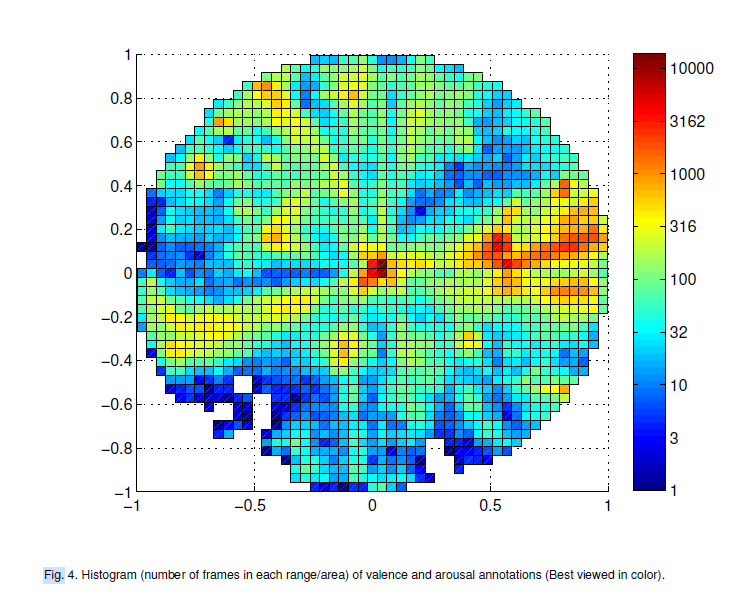

No we will compare to given table:

In [60]:
# Define the general heatmap parameters
total_bins = 10
bin_edges = np.linspace(-1, 1, total_bins+1)  
# Calculate the 2D histogram
hist, arousal_edges, valence_edges = np.histogram2d(
    joint_annotations['arousal'], 
    joint_annotations['valence'], 
    bins=[bin_edges, bin_edges]
)

valence_edges = np.round(valence_edges, 1); arousal_edges = np.round(arousal_edges, 1)

# Create a pretty table
table = PrettyTable()

# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(hist[i, j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)

# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |     0.0     |     0.0     |    2538.0   |    1228.0   |   3407.0   |   1445.0  |   1289.0  |   494.0   |    0.0    |    0.0    |
|    0.8 - 0.6    |     0.0     |    2560.0   |    6059.0   |    3475.0   |   3978.0   |   2127.0  |   2902.0  |   623.0   |   533.0   |    0.0    |
|    0.6 - 0.4    |    468.0    |    6389.0   |    1741.0   |    2967.0   |   1599.0   |   1872.0  |   1263.0  |   329.0   |   832.0   |   405.0   |
|    0.4 - 0.2    |    454.0    |    862.0    |    2835.0   |    4969.0   |   1755.0   |   648.0   |   241

Now we copied the original data. 

In [61]:
# Convert the table to a 2D numpy array
paper_histogram = np.array([
    [0, 0, 21, 674, 1021, 521, 60, 57, 0, 0],
    [0, 74, 161, 561, 706, 1006, 432, 738, 530, 0],
    [638, 720, 312, 505, 2689, 1905, 1228, 992, 3891, 957],
    [6770, 9283, 3884, 2473, 5530, 2296, 3506, 1824, 2667, 1125],
    [3331, 1286, 2971, 4854, 14083, 15300, 4104, 9998, 13842, 9884],
    [395, 577, 5422, 3675, 9024, 23201, 6237, 42219, 23281, 21040],
    [787, 1364, 3700, 6344, 2804, 1745, 821, 5241, 10619, 9934],
    [610, 7800, 2645, 3571, 2042, 2517, 1993, 467, 1271, 921],
    [0, 3537, 8004, 4374, 5066, 3379, 4169, 944, 873, 0],
    [0, 0, 4123, 1759, 4836, 1845, 1672, 739, 0, 0]
])

In [62]:
# Create a pretty table
table = PrettyTable()

# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(paper_histogram[i, j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)

# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |      0      |      0      |     4123    |     1759    |    4836    |    1845   |    1672   |    739    |     0     |     0     |
|    0.8 - 0.6    |      0      |     3537    |     8004    |     4374    |    5066    |    3379   |    4169   |    944    |    873    |     0     |
|    0.6 - 0.4    |     610     |     7800    |     2645    |     3571    |    2042    |    2517   |    1993   |    467    |    1271   |    921    |
|    0.4 - 0.2    |     787     |     1364    |     3700    |     6344    |    2804    |    1745   |    82

Difference:

In [63]:
# Create a pretty table
table = PrettyTable()

# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(paper_histogram[i, j]-hist[i,j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)

# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |     0.0     |     0.0     |    1585.0   |    531.0    |   1429.0   |   400.0   |   383.0   |   245.0   |    0.0    |    0.0    |
|    0.8 - 0.6    |     0.0     |    977.0    |    1945.0   |    899.0    |   1088.0   |   1252.0  |   1267.0  |   321.0   |   340.0   |    0.0    |
|    0.6 - 0.4    |    142.0    |    1411.0   |    904.0    |    604.0    |   443.0    |   645.0   |   730.0   |   138.0   |   439.0   |   516.0   |
|    0.4 - 0.2    |    333.0    |    502.0    |    865.0    |    1375.0   |   1049.0   |   1097.0  |   580

In [64]:
hist_df_difference = pd.DataFrame(
    [(x, y, int(paper_histogram[i, j]-hist[i,j])) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['arousal', 'valence', 'count']
)
# Delete entries where count is equal to 0
hist_df_difference = hist_df_difference.query('count != 0')

In [65]:
# Create the histogram using Altair
difference_histogram_2d = alt.Chart(hist_df_difference).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=valence_edges, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=arousal_edges, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    width=400,
    height=400
)

# Overlay the heatmap and the dotted grid
difference_histogram_2d_with_dotted_grid = (difference_histogram_2d).properties(title = 'Number of missing data with respect to paper').interactive()
difference_histogram_2d_with_dotted_grid

alt.Chart(...)

Now we will normalize this data, to get a sense on how much we are loosing. 

In [66]:
hist_df_difference_normed = pd.DataFrame(
    [(x, y, (paper_histogram[i, j]-hist[i,j])/paper_histogram[i, j]) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['arousal', 'valence', 'count'])

# Delete entries where count is equal to NaN
hist_df_difference_normed = hist_df_difference_normed.dropna(subset=['count'])

/tmp/ipykernel_3817453/157876346.py:2: RuntimeWarning: invalid value encountered in scalar divide
  [(x, y, (paper_histogram[i, j]-hist[i,j])/paper_histogram[i, j]) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],


In [67]:
# Create the histogram using Altair
difference_histogram_2d = alt.Chart(hist_df_difference_normed).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=valence_edges, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=arousal_edges, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='darkgold', domain=[0, 1.05]), 
                    legend=alt.Legend(title="Count of records")),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        'count:Q'
    ]
).properties(
    width=400,
    height=400
)

# Overlay the heatmap and the dotted grid
difference_histogram_2d_with_dotted_grid = (difference_histogram_2d).properties(title = 'Percentage of missing data with respect to paper').interactive()
difference_histogram_2d_with_dotted_grid

alt.Chart(...)

We can obsrve that

## Categorical emotions

In [68]:
counts = joint_annotations['cat_emot'].value_counts().reset_index()

counts['cat_emot_label'] = counts['cat_emot'].map(dict(enumerate(AFFECTNET_CAT_EMOT)))

In [69]:
# Create a histogram with mean line for valence
cat_emot_bar_plot = alt.Chart(counts).mark_bar(color="steelblue", width=20).encode(
    alt.X("cat_emot_label:N", sort='-y', 
          axis=alt.Axis(labelAngle=0, title="Categorical emotions", labelFlush=False)),
    alt.Y('count:Q'),
    tooltip=[
        alt.Tooltip('cat_emot_label:N', title='Categorical emotion'),
        alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Categorical emotions distribution', fontSize=16),
    width=400,
    height=400
)

cat_emot_bar_plot.interactive()

alt.Chart(...)

# Continuous distribution conditioned to a emotion.

Now I will focus my analysis on seeing the distribution of the data conditioned to a emotion. This way we can see in which sectors each categorical emotion is used to be. 

In [70]:
# Define the general heatmap parameters
total_bins = 40
step_size = 0.25; num_steps = 7
axis_steps= np.arange(-1, 1+step_size, step_size); bin_edges = np.linspace(-1, 1, total_bins+1) 

print ("The maximum number of records in a bin is:", int(max_count))
print ("The logarithmic scale is:", legend_steps_log)

The maximum number of records in a bin is: 14617
The logarithmic scale is: [    1     4    24   120   597  2956 14617]


### Neutral

In [71]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 0] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [72]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
neutral_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Neutral').interactive()
neutral_histogram2d

alt.LayerChart(...)

## Happy

In [73]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 1] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [74]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
happy_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Happy').interactive()
happy_histogram2d

alt.LayerChart(...)

## Sad

In [75]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 2] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [76]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
sad_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Sad').interactive()
sad_histogram2d

alt.LayerChart(...)

### Surprise

In [77]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 3] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [78]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
surprise_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Surprise').interactive()
surprise_histogram2d

alt.LayerChart(...)

### Fear

In [79]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 4] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [80]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
fear_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Fear').interactive()
fear_histogram2d

alt.LayerChart(...)

### Disgust

In [81]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 5] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [82]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
disgust_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Disgust').interactive()
disgust_histogram2d

alt.LayerChart(...)

### Anger

In [83]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 6] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [84]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
anger_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Anger').interactive()
anger_histogram2d

alt.LayerChart(...)

## Contempt


In [85]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 7] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [86]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
contempt_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Contempt').interactive()
contempt_histogram2d

alt.LayerChart(...)

## All emotions:

In [87]:
up_histogram2d = alt.hconcat(neutral_histogram2d, happy_histogram2d, sad_histogram2d, surprise_histogram2d).resolve_scale(x='shared', y='shared')
down_histogram = alt.hconcat(fear_histogram2d, disgust_histogram2d, anger_histogram2d, contempt_histogram2d).resolve_scale(x='shared', y='shared')
all_histogram2d = alt.vconcat(up_histogram2d, down_histogram).properties(title = alt.Title (text='Continuous emotion distribution conditioned to categorical emotion'
                                                                                            ,anchor='middle', fontSize=20, dy=-20))

all_histogram2d

alt.VConcatChart(...)

## Image size distribution

In order to make the computations faster, I will analyze 2500 photos per split and show the results. This way we can see the distribution of the image sizes in the dataset (I expect that this sample is representative of the whole dataset).

In [100]:
# Create a list to store all the labels
width = []
height = []
ratio = []

# Get image sizes using the annotations
for data_split in annotations.keys():
    random_idx_list = np.random.randint(0, len(annotations[data_split]), 2500)
    for photo_idx in random_idx_list:
        sample = annotations[data_split].loc[photo_idx]
        img_path = sample['path']
        img = Image.open(img_path)
        width.append(img.size[0])
        height.append(img.size[1])
        ratio.append(img.size[0]/img.size[1])
        

# Create a pandas dataframe 
df1 = pd.DataFrame(width, columns=['Width'])
df2 = pd.DataFrame(height, columns=['Height'])
df3 = pd.DataFrame(ratio, columns=['Ratio'])
# Count the number of occurrences
df1['Count'] = df1.groupby(['Width'])['Width'].transform('count')
df2['Count'] = df2.groupby(['Height'])['Height'].transform('count')
df3['Count'] = df3.groupby(['Ratio'])['Ratio'].transform('count')
# Drop duplicates
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
df3 = df3.drop_duplicates()

In [95]:
hist_width= alt.Chart(df1).mark_bar(color='steelblue').encode(
    x=alt.X('Width:Q', title='Width value (px)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df1['Width'])))),
    y=alt.Y('Count:Q', title='Count of people'),
).properties(
    title = alt.TitleParams(text = 'Photo width distribution', fontSize=20),
    width = 400,
    height = 400
)

hist_height = alt.Chart(df2).mark_bar(color='steelblue').encode(
    x=alt.X('Height:Q', title='Height value (px)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df2['Height'])))),
    y=alt.Y('Count:Q', title='Count of people'),
).properties(
    title = alt.TitleParams(text = 'Photo height distribution', fontSize=20, baseline='line-top'),
    width = 400,
    height = 400
)

# Combine the two charts horizontally and share the same y-axis
width_height_chart = alt.hconcat(hist_width, hist_height).resolve_scale(y='shared')

width_height_chart

alt.HConcatChart(...)

In [96]:
hist_ratio= alt.Chart(df3).mark_bar(color='steelblue').encode(
    x=alt.X('Ratio:Q', title='Ratio (log-scale)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df3['Ratio'])))).scale(type="log"),
    y=alt.Y('Count:Q', title='Count of people'),
).properties(
    title = alt.TitleParams(text = 'Bbox ratio (width/heigth) distribution', fontSize=20),
    width = 400,
    height = 400
)

hist_ratio

alt.Chart(...)

# 2. Data exploration over all data

# 3. Data exploration over each split

# 4. Conclusions